Training Neural Network...
Epoch 0, Training Loss: 0.6846, Validation Loss: 0.6837
Epoch 100, Training Loss: 0.6443, Validation Loss: 0.6499
Epoch 200, Training Loss: 0.6111, Validation Loss: 0.6196
Epoch 300, Training Loss: 0.5830, Validation Loss: 0.5956
Epoch 400, Training Loss: 0.5577, Validation Loss: 0.5763
Epoch 500, Training Loss: 0.5337, Validation Loss: 0.5614
Epoch 600, Training Loss: 0.5127, Validation Loss: 0.5490
Epoch 700, Training Loss: 0.4952, Validation Loss: 0.5389
Epoch 800, Training Loss: 0.4807, Validation Loss: 0.5304
Epoch 900, Training Loss: 0.4694, Validation Loss: 0.5234
Epoch 1000, Training Loss: 0.4606, Validation Loss: 0.5186
Epoch 1100, Training Loss: 0.4535, Validation Loss: 0.5158
Epoch 1200, Training Loss: 0.4479, Validation Loss: 0.5137
Epoch 1300, Training Loss: 0.4434, Validation Loss: 0.5139
Epoch 1400, Training Loss: 0.4400, Validation Loss: 0.5147
Epoch 1500, Training Loss: 0.4370, Validation Loss: 0.5159
Epoch 1600, Training Loss: 0.4348, Valida

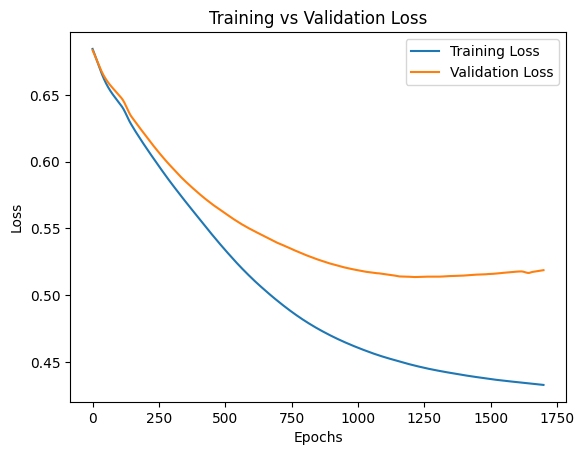

In [5]:
import numpy as np
import pandas as pd
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time

# Load diabetes dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/diabetes.csv')

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Scale inputs
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Train/Validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)


class FCNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.hidden = torch.nn.Linear(input_dim, 8)
        self.output = torch.nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)   # raw logits


def train_nn_model(X_train, y_train, X_val, y_val, learning_rate, epochs):
    input_dim = X_train.shape[1]
    model = FCNN(input_dim)

    # Correct loss for binary classification
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    training_loss = []
    validation_loss = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        logits = model(X_train)
        loss = criterion(logits, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = criterion(val_logits, y_val)

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

        training_loss.append(loss.item())
        validation_loss.append(val_loss.item())

    end_time = time.time()
    training_time = end_time - start_time

    return model, training_loss, validation_loss, training_time


learning_rate = 0.001
epochs = 1700

print("Training Neural Network...")
model, train_loss, val_loss, training_time = train_nn_model(
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, learning_rate, epochs
)

print(f"Total Training Time: {training_time:.2f} seconds")

# Compute predictions
with torch.no_grad():
    y_val_logits = model(X_val_tensor)
    y_val_probs = torch.sigmoid(y_val_logits)
    y_val_pred = (y_val_probs > 0.5).float()

# Compute classification accuracy
accuracy = (y_val_pred.eq(y_val_tensor).sum().item()) / len(y_val_tensor)
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()
